In [543]:
import os
import random
import trimesh
import pyrender
import warnings
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as R

MODEL_DIR = "models_sm/"

IMG_SIZE = 512

all_xyzms = [
    v for v in product((-1, 0, 1), repeat=3)
    if v != (0, 0, 0) and sum(x != 0 for x in v) in (1, 3)
]

def load_step_part(filepath):
    mesh = trimesh.load_mesh(filepath)
    mesh.apply_translation(-mesh.centroid)
    mesh.apply_scale(1000)
    return mesh

def random_grayscale_color(min_val=0.2, max_val=0.8, tint_strength=0.0):
    base = np.random.uniform(min_val, max_val)
    r = np.clip(base + np.random.uniform(-tint_strength, tint_strength), 0, 1)
    g = np.clip(base + np.random.uniform(-tint_strength, tint_strength), 0, 1)
    b = np.clip(base + np.random.uniform(-tint_strength, tint_strength), 0, 1)
    return np.array([r, g, b])

def look_at(v_e, v_t=np.array((0, 0, 0)), up=np.array((0, 1, 0))):
    forward = v_t - v_e
    forward /= np.linalg.norm(forward)
    up = np.array([1, 0, 0]) if abs(np.dot(forward, up)) > 0.999 else up

    right = np.cross(forward, up)
    right /= np.linalg.norm(right)

    up = np.cross(right, forward)

    rot = np.eye(4)
    rot[:3, 0] = right
    rot[:3, 1] = up
    rot[:3, 2] = -forward

    trans = np.eye(4)
    trans[:3, 3] = v_e

    pose = trans @ rot
    return pose

def intersects(bounds1, bounds2):
    return np.all(bounds1[0] < bounds2[1]) and np.all(bounds1[1] > bounds2[0])

def path_to_mesh(path):
    lines = []
    for entity in path.entities:
        segment = entity.discrete(path.vertices)
        for i in range(len(segment) - 1):
            lines.append(segment[i])
            lines.append(segment[i + 1])

    lines_np = np.array(lines, dtype=np.float32)

    line_mesh = pyrender.Primitive(
        positions=lines_np,
        mode=1,
        material=pyrender.MetallicRoughnessMaterial(
            baseColorFactor=(0.0, 0, 0),
            metallicFactor=0.8,
            roughnessFactor=0.8,
        ),
    )
    return pyrender.Mesh([line_mesh])

def render(m_transformed: list[trimesh.Trimesh], o_transformed, r: pyrender.Renderer, xyzm: tuple[int]):
    full_mesh = trimesh.Scene(m_transformed).to_geometry()
    bounds = full_mesh.bounds
    size = 2 * np.max((np.linalg.norm(bounds[1]), np.linalg.norm(bounds[0])))

    direction = xyzm
    direction = direction / np.linalg.norm(direction)

    cam_dist = size * 0.5  # adjust zoom level
    cam_position = direction * cam_dist
    cam_pose = look_at(cam_position)

    scene = pyrender.Scene(bg_color=(0.95, 0.95, 0.95, 1.0), ambient_light=[0.3, 0.3, 0.3, 1.0])

    for xyzm in all_xyzms:
        light_pose = look_at(cam_dist * np.array(xyzm, dtype=np.dtypes.Float64DType))
        light = pyrender.DirectionalLight(intensity=2.5)
        scene.add(light, pose=light_pose)

    for mesh, outline in zip(m_transformed, o_transformed):
        scene.add(
            pyrender.Mesh.from_trimesh(mesh, material=pyrender.MetallicRoughnessMaterial(
                baseColorFactor=(0.4, 0.4, 0.4, 1.0),
                metallicFactor=0.8,
                roughnessFactor=0.8,
            ), smooth=False)
        )
        scene.add(path_to_mesh(outline))

    camera = pyrender.OrthographicCamera(cam_dist, cam_dist, zfar=1000)

    scene.add(camera, pose=cam_pose)

    color, _ = r.render(scene)
    return color

In [599]:
steps = [f for f in os.listdir(MODEL_DIR) if f.lower().endswith(".step")]
meshes = [load_step_part(os.path.join(MODEL_DIR, f)) for f in steps]
outlines = []

for m in meshes:
    m = m.copy()
    m.merge_vertices()
    outlines.append(trimesh.load_path(m.vertices[m.face_adjacency_edges[m.face_adjacency_angles >= np.radians(90)]]))

r = pyrender.OffscreenRenderer(IMG_SIZE, IMG_SIZE)
warnings.filterwarnings("ignore", category=UserWarning)  # ignore annoying scipy gimbal lock warnings

In [342]:
def rand_face_transform(target_mesh, source_mesh):
    target_box = target_mesh.bounding_box_oriented
    source_box = source_mesh.bounding_box_oriented

    side_faces = [0, 2, 3, 5]  # exclude faces 1 and 4 (Y-axis faces)

    target_face = 0 # random.choice(side_faces)
    source_face = 3 # random.choice(side_faces)

    target_min, target_max = target_box.bounds
    source_min, source_max = source_box.bounds

    def get_face_vector(idx, min_, max_):
        axis = idx % 3
        direction = -1 if idx < 3 else 1
        face_center = np.array(
            [
                (
                    min_[i]
                    if direction == -1 and i == axis
                    else (
                        max_[i]
                        if direction == 1 and i == axis
                        else (min_[i] + max_[i]) / 2
                    )
                )
                for i in range(3)
            ]
        )
        normal = np.eye(3)[axis] * direction
        print(f"normal: {normal}")
        return face_center, normal

    t_face_center, t_normal = get_face_vector(target_face, target_min, target_max)
    s_face_center, s_normal = get_face_vector(source_face, source_min, source_max)

    v1 = s_normal / np.linalg.norm(s_normal)
    v2 = - t_normal / np.linalg.norm(t_normal)

    
    axis = np.cross(v1, v2)
    angle = np.arccos(np.clip(np.dot(v1, v2), -1, 1))
    print(f"axis: {axis}")
    print(f"angle: {angle}")
    if np.linalg.norm(axis) < 1e-6:
        R_mat = np.eye(3)
    else:
        axis = axis / np.linalg.norm(axis)
        R_mat = R.from_euler("xyz", np.array([np.radians(-90), 0, 0]) + angle * axis).as_matrix() # trimesh.transformations.rotation_matrix(angle, axis)[:3, :3]

    s_transformed_face = R_mat @ s_face_center
    translation = t_face_center - s_transformed_face

    # Clamp Y to base level
    # translation[1] = target_min[1]  # or set to 0.0 if you want everything flat on ground

    rotation_euler = R.from_matrix(R_mat).as_euler("xyz", degrees=True)

    return translation, rotation_euler


def assemble(mesh_list, outline_list, max_attempts=100):
    placed = []
    poses = []

    rot_euler_first = [90, 0, 0]
    T0 = np.eye(4)
    T0[:3, :3] = R.from_euler("xyz", rot_euler_first, degrees=True).as_matrix()

    mesh0 = mesh_list[0].copy()
    mesh0.apply_transform(T0)
    meshes_transformed = [mesh0]

    outline0 = outline_list[0].copy()
    outline0.apply_transform(T0)
    outlines_transformed = [outline0]

    placed.append(mesh0)
    poses.append((np.zeros(3), rot_euler_first))

    for mesh, outline in zip(mesh_list[1:], outline_list[1:]):
        added = False
        attempts = 0

        while not added and attempts < max_attempts:
            target = random.choice(placed)
            position, rotation_euler = rand_face_transform(target, mesh)

            T = np.eye(4)
            T[:3, :3] = R.from_euler("xyz", rotation_euler, degrees=True).as_matrix()
            T[:3, 3] = position

            mesh_transformed = mesh.copy()
            mesh_transformed.apply_transform(T)

            # if not any(intersects(mesh_transformed.bounds, p.bounds) for p in placed):
            placed.append(mesh_transformed)

            meshes_transformed.append(mesh_transformed)

            outline_transformed = outline.copy()
            outline_transformed.apply_transform(T)
            outlines_transformed.append(outline_transformed)

            poses.append((position, rotation_euler))
            added = True
            # else:
            #     print("FAILED")

            attempts += 1

    all_bounds = np.vstack([m.bounds for m in meshes_transformed])
    com = (np.min(all_bounds, axis=0) + np.max(all_bounds, axis=0)) / 2 # centroid

    mesh_centers = np.array([m.bounding_box.centroid for m in meshes_transformed])
    distances = np.linalg.norm(mesh_centers - com, axis=1)
    origin_idx = np.argmin(distances)
    origin = mesh_centers[origin_idx]

    offset = origin

    for i, (m, o) in enumerate(zip(meshes_transformed, outlines_transformed)):
        m.apply_translation(-offset)
        o.apply_translation(-offset)
        pos, rot = poses[i]
        new_pos = pos - offset
        poses[i] = (new_pos, rot)

    return meshes_transformed, outlines_transformed, poses, origin_idx

In [ ]:
def assemble_2d(meshes: list[trimesh.Trimesh], outlines):
    meshes_transformed = []
    outlines_transformed = []
    positions = []

    # Fix first mesh at origin
    first_mesh = meshes[0].copy()
    first_outline = outlines[0].copy()

    T0 = trimesh.transformations.rotation_matrix(np.radians(90), [1, 0, 0])
    first_mesh.apply_transform(T0)
    first_outline.apply_transform(T0)

    bbox = first_mesh.bounds
    offset = -bbox[0]
    first_mesh.apply_translation(offset)
    first_outline.apply_translation(offset)
    meshes_transformed.append(first_mesh)
    outlines_transformed.append(first_outline)
    positions.append(first_mesh.bounds)

    # Track where we can attach next object
    attach_points = [first_mesh.bounds[1]]  # max bound of first mesh

    for mesh, outline in zip(meshes[1:], outlines[1:]):
        m = mesh.copy()
        o = outline.copy()

        # Rotate 90 deg about x and random 90-degree rotation about y
        R1 = trimesh.transformations.rotation_matrix(np.radians(90), [1, 0, 0])
        m.apply_transform(R1)
        o.apply_transform(R1)
        
        R2 = trimesh.transformations.rotation_matrix(np.radians(random.choice([0, 90, 180, 270])), [0, 1, 0])
        m.apply_transform(R2)
        o.apply_transform(R2)

        mesh_bbox = m.bounds

        # Determine direction to attach (randomly choose X or Z axis)
        axis = random.choice([0, 2])  # 0 for x, 2 for z

        # Choose a previous mesh to attach to
        ref_mesh_bounds = random.choice(positions)
        ref_max = ref_mesh_bounds[1]
        ref_min = ref_mesh_bounds[0]

        # Position the mesh adjacent to the chosen face
        pos = np.zeros(3)
        pos[1] = -mesh_bbox[0][1]  # snap to y=0
        if axis == 0:  # x-axis
            pos[0] = ref_max[0] - mesh_bbox[0][0]  # place next to +x face
            pos[2] = ref_min[2] - mesh_bbox[0][2]  # align along z
        else:  # z-axis
            pos[2] = ref_max[2] - mesh_bbox[0][2]  # place next to +z face
            pos[0] = ref_min[0] - mesh_bbox[0][0]  # align along x

        m.apply_translation(pos)
        meshes_transformed.append(m)
        o.apply_translation(pos)
        outlines_transformed.append(o)
        positions.append(m.bounds)

    # Compute centroid of the full assembly
    combined = trimesh.util.concatenate(meshes_transformed)
    centroid = combined.centroid

    # Find mesh closest to the centroid
    centroids = [m.centroid for m in meshes_transformed]
    distances = [np.linalg.norm(c - centroid) for c in centroids]
    idx_closest = np.argmin(distances)

    # Translate everything so the closest mesh's centroid is at (0, 0, 0)
    origin_shift = -centroids[idx_closest]
    for m, o in zip(meshes_transformed, outlines_transformed):
        m.apply_translation(origin_shift)
        o.apply_translation(origin_shift)

    return meshes_transformed, outlines_transformed

In [ ]:
def face_normals_and_origins(mesh):
    face_centers = mesh.triangles_center
    face_normals = mesh.face_normals
    normals = []
    origins = []

    for i in range(len(face_normals)):
        normals.append(face_normals[i])
        origins.append(face_centers[i])
    return normals, origins

def get_unique_face_planes(mesh):
    normals, origins = face_normals_and_origins(mesh)
    face_planes = {}

    for n, o in zip(normals, origins):
        key = tuple(np.round(n, 3))
        if key not in face_planes:
            face_planes[key] = []
        face_planes[key].append(o)

    unique_planes = []
    for n_key, centers in face_planes.items():
        center = np.mean(centers, axis=0)
        normal = np.array(n_key)
        unique_planes.append((normal, center))
    return unique_planes

def align_face_to_face(mesh, mesh_face_normal, mesh_face_origin, ref_face_normal, ref_face_origin):
    rot_axis = np.cross(mesh_face_normal, -ref_face_normal)
    if np.linalg.norm(rot_axis) > 1e-6:
        rot_axis /= np.linalg.norm(rot_axis)
        angle = np.arccos(np.clip(np.dot(mesh_face_normal, -ref_face_normal), -1.0, 1.0))
        rot_matrix = trimesh.transformations.rotation_matrix(angle, rot_axis)
        mesh.apply_transform(rot_matrix)
    translation = ref_face_origin - mesh_face_origin
    mesh.apply_translation(translation)

def apply_transform_to_pair(mesh, outline, matrix):
    mesh.apply_transform(matrix)
    if outline is not None:
        outline.apply_transform(matrix)

def arrange_touching_meshes(meshes, outlines, max_attempts_per_mesh=50):
    placed_meshes = []
    placed_outlines = []

    base_mesh = meshes[0].copy()
    base_outline = outlines[0].copy() if outlines else None

    transforms = []

    x_rot = trimesh.transformations.rotation_matrix(np.radians(90), [1, 0, 0])
    y_rot = trimesh.transformations.rotation_matrix(np.radians(random.choice([0, 90, 180, 270])), [0, 1, 0])
    tform = trimesh.transformations.concatenate_matrices(x_rot, y_rot)

    base_mesh.apply_transform(tform)
    if base_outline: base_outline.apply_transform(tform)

    base_shift = -base_mesh.bounds[0]
    base_mesh.apply_translation(base_shift)
    if base_outline: base_outline.apply_translation(base_shift)

    placed_meshes.append(base_mesh)
    if outlines: placed_outlines.append(base_outline)
    transforms.append((tform, base_shift))

    for m, o in zip(meshes[1:], outlines[1:]):
        mesh = m.copy()
        outline = o.copy()

        success = False
        for attempt in range(max_attempts_per_mesh):
            mesh_try = mesh.copy()
            outline_try = outline.copy()

            x_rot = trimesh.transformations.rotation_matrix(np.radians(90), [1, 0, 0])
            y_rot = trimesh.transformations.rotation_matrix(np.radians(random.choice([0, 90, 180, 270])), [0, 1, 0])
            tform = trimesh.transformations.concatenate_matrices(x_rot, y_rot)

            mesh_try.apply_transform(tform)
            outline_try.apply_transform(tform)

            ref_mesh = random.choice(placed_meshes)
            ref_faces = get_unique_face_planes(ref_mesh)
            mesh_faces = get_unique_face_planes(mesh_try)

            ref_normal, ref_origin = random.choice(ref_faces)
            mesh_normal, mesh_origin = random.choice(mesh_faces)

            translation = trimesh.transformations.translation_matrix(ref_origin - mesh_origin)
            mesh_try.apply_transform(translation)
            if outline_try: outline_try.apply_transform(translation)

            if not any(intersects(mesh_try.bounds, p.bounds) for p in placed_meshes):
                placed_meshes.append(mesh_try)
                placed_outlines.append(outline_try)
                transforms.append((tform, translation))
                success = True
                break

        if not success:
            raise RuntimeError(f"Couldn't place mesh after {max_attempts_per_mesh} attempts.")

    all_combined = trimesh.util.concatenate(placed_meshes)
    global_centroid = all_combined.centroid

    centroids = [m.centroid for m in placed_meshes]
    distances = [np.linalg.norm(c - global_centroid) for c in centroids]
    idx_closest = np.argmin(distances)
    shift = -centroids[idx_closest]

    for mesh in placed_meshes:
        mesh.apply_translation(shift)
    if outlines:
        for outline in placed_outlines:
            outline.apply_translation(shift)

    return placed_meshes, placed_outlines if outlines else None

In [ ]:
GRID_SIZE = 24

def rotate_mesh(mesh, by=None):
    rot_x = trimesh.transformations.rotation_matrix(np.radians(90), [1, 0, 0])
    y_angle = by or random.choice([0, 90, 180, 270])
    rot_y = trimesh.transformations.rotation_matrix(np.radians(y_angle), [0, 1, 0])
    transform = trimesh.transformations.concatenate_matrices(rot_y, rot_x)
    mesh = mesh.copy()
    mesh.apply_transform(transform)
    return mesh, transform, y_angle

def get_footprint(mesh):
    bbox = mesh.bounding_box.extents
    x_cells = int(round(bbox[0] / GRID_SIZE))
    z_cells = int(round(bbox[2] / GRID_SIZE))
    return (x_cells, z_cells)

def cornerify(mesh, outline):
    bbox = mesh.bounding_box.bounds
    min_corner = bbox[0]
    mesh.apply_translation(-min_corner)
    outline.apply_translation(-min_corner)
    
def get_min_corner(mesh):
    return mesh.bounding_box.bounds[1]
    
def get_adjacent_positions(occupied, footprint): # just a lil graph theory
    adj_positions = set()
    directions = [(1,0), (-1,0), (0,1), (0,-1)]
    for (x,y) in occupied:
        for dx, dz in directions:
            cx = x + dx
            cz = y + dz

            candidate_cells = set(
                (cx + i, cz + j)
                for i in range(footprint[0])
                for j in range(footprint[1])
            )

            if not candidate_cells & occupied:
                adj_positions.add((cx, cz))

    return list(adj_positions)

def place_parts(meshes, outlines=None):
    if outlines is None:
        outlines = [None] * len(meshes)

    placed_meshes = []
    placed_outlines = []
    transforms = []
    y_rotations = []
    grid_positions = []

    # first anchor at origin
    mesh, tf, y_angle = rotate_mesh(meshes[0].copy())
    outline = outlines[0].copy() if outlines[0] is not None else None
    if outline:
        outline.apply_transform(tf)
    footprint = get_footprint(mesh)

    cornerify(mesh, outline)
    placed_meshes.append(mesh)
    placed_outlines.append(outline)
    transforms.append(tf)
    y_rotations.append(y_angle)
    grid_positions.append((0,0))  # first mesh at origin

    occupied = set((x, z) for x in range(footprint[0]) for z in range(footprint[1]))

    for mesh, outline in zip(meshes[1:], outlines[1:]):
        success = False
        for _ in range(100):
            mesh_rot, tf, y_angle = rotate_mesh(mesh)
            footprint = get_footprint(mesh_rot)

            candidates = get_adjacent_positions(occupied, footprint)
            if not candidates:
                continue

            pos = random.choice(candidates)
            x_grid, z_grid = pos

            mesh_copy = mesh_rot.copy()
            outline_copy = outline.copy() if outline is not None else None
            if outline_copy:
                outline_copy.apply_transform(tf)
            cornerify(mesh_copy, outline_copy)
            mesh_copy.apply_translation([x_grid * GRID_SIZE, 0, z_grid * GRID_SIZE])

            if outline_copy:
                outline_copy.apply_translation([x_grid * GRID_SIZE, 0, z_grid * GRID_SIZE])

            new_cells = set(
                (x_grid + dx, z_grid + dz)
                for dx in range(footprint[0])
                for dz in range(footprint[1])
            )
            if new_cells & occupied:
                continue # overlap, try again

            occupied |= new_cells
            placed_meshes.append(mesh_copy)
            placed_outlines.append(outline_copy)
            transforms.append(tf)
            y_rotations.append(y_angle)
            grid_positions.append((x_grid, z_grid))
            success = True
            break

        if not success:
            raise RuntimeError(f"Could not place mesh after 100 attempts")

    # recentering
    centroids = np.array([m.centroid for m in placed_meshes])
    assembly_centroid = np.mean(centroids, axis=0)
    distances = np.linalg.norm(centroids - assembly_centroid, axis=1)
    anchor_idx = int(np.argmin(distances))
    offset = -placed_meshes[anchor_idx].centroid

    for mesh, outline in zip(placed_meshes, placed_outlines):
        mesh.apply_translation(offset)
        if outline:
            outline.apply_translation(offset)

    final_transforms = []
    for i, (x_grid, z_grid) in enumerate(grid_positions):
        min_corner = get_min_corner(rotate_mesh(meshes[i], y_rotations[i])[0])
        final_x = x_grid * GRID_SIZE + offset[0] + min_corner[0]
        final_z = z_grid * GRID_SIZE + offset[2] + min_corner[2]

        final_transforms.append({
            "translation": {"x": f"{final_x:z.2f}", "y": f"{final_z + 0:z.2f}"},
            "rotation": y_rotations[i]
        })

    return placed_meshes, placed_outlines, final_transforms

Parts (n=3): UChannel1H, UChannel5H, UChannel2H
[{"name": "UChannel1H", "translation": {"x": "-24.00", "y": "-96.00"}, "rotation": 90}, {"name": "UChannel5H", "translation": {"x": "-0.00", "y": "-0.00"}, "rotation": 180}, {"name": "UChannel2H", "translation": {"x": "36.00", "y": "96.00"}, "rotation": 270}]


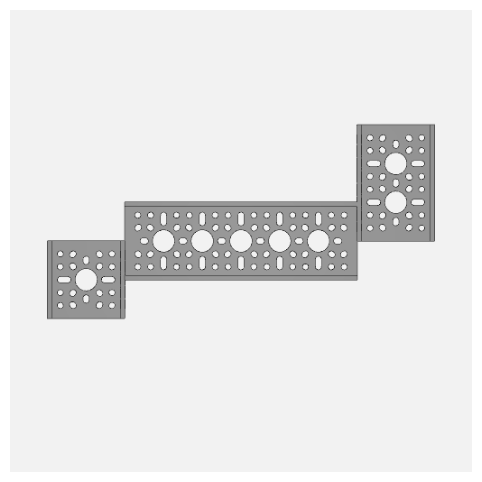

In [582]:
import json

idxs = np.random.choice(range(len(steps)), 3, replace=False)
file_names = [steps[i] for i in idxs]

part_names = [os.path.splitext(f)[0] for f in file_names]
print(f"Parts (n={len(file_names)}): {', '.join(part_names)}")

chosen_meshes = [meshes[i] for i in idxs]
chosen_outlines = [outlines[i] for i in idxs]

meshes_transformed, outlines_transformed, indexed_transforms = place_parts(chosen_meshes, chosen_outlines)

named_transforms = [
    {
        "name": os.path.splitext(n)[0],
        "translation": t["translation"],
        "rotation": t["rotation"],
    } for t, n in zip(indexed_transforms, file_names)
]
print(json.dumps(named_transforms))

img = render(meshes_transformed, outlines_transformed, r, [0, 1, 0])

plt.figure(figsize=(8, 6))
plt.axis("off")
plt.imshow(img)
plt.show()

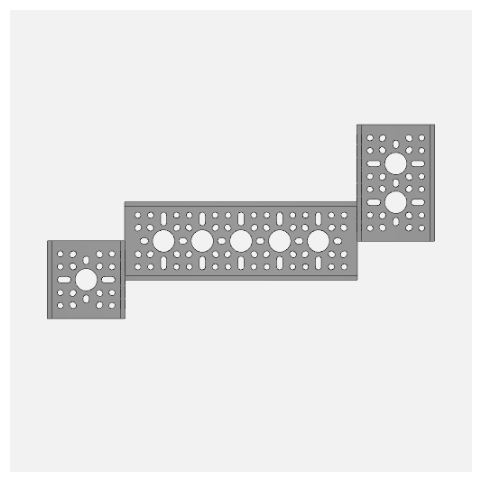

In [601]:
def reconstruct(transforms):
    ms = []
    oss = []
    for t in transforms:
        idx = steps.index(t["name"] + ".STEP")
        mesh = meshes[idx].copy()
        outline = outlines[idx].copy()

        x, z = float(t["translation"]["x"]), float(t["translation"]["y"])
        mesh.apply_transform(
            trimesh.transformations.concatenate_matrices(
                trimesh.transformations.rotation_matrix(np.radians(float(t["rotation"])), (0, 1, 0)),
                trimesh.transformations.rotation_matrix(np.radians(90), (1, 0, 0))
            )
        )
        mesh.apply_translation((x, 0, z))
        
        outline.apply_transform(
            trimesh.transformations.concatenate_matrices(
                trimesh.transformations.rotation_matrix(np.radians(float(t["rotation"])), (0, 1, 0)),
                trimesh.transformations.rotation_matrix(np.radians(90), (1, 0, 0))
            )
        )
        outline.apply_translation((x, 0, z))
        
        ms.append(mesh)
        oss.append(outline)

    return render(ms, oss, r, [0, 1, 0])

plt.figure(figsize=(8, 6))
plt.axis("off")
plt.imshow(reconstruct(named_transforms))
plt.show()